## first import 

In [1]:
import torch
import triton
import random
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
import flash_attn
print(torch.__version__)
print(triton.__version__)
print(flash_attn.__version__)
def compare(x, y, prefix=""):
    if x is None or y is None:
        return
    assert x.shape == y.shape
    if 0 in list(x.shape):
        return
    
    if any([x.dtype == torch.float32, y.dtype==torch.float32]):
        x,y = x.float(), y.float()
    diff = (x-y).abs()
    if prefix:
        print(prefix, end=": ")
    print(f"max_diff: {diff.max().item()}, mean_diff: {diff.mean().item()}")

def generate_cu_seqlens(end=8192, mean=2048, std=512):
    r = [0]
    while r[-1] < end:
        a = random.randint(mean-std, mean+std)
        r.append(r[-1] + a)
    r[-1] = end
    cu_seqlens = torch.tensor(r, device=torch.cuda.current_device(), dtype=torch.int32)
    return cu_seqlens

def set_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import numpy as np

def get_tabels(x, y, cu_seqlens, seed=42, return_cmp_slot_mapping=False):
    B = len(cu_seqlens) - 1
    total_num_blocks, block_size, H, D = y.shape
    y = y.view(-1, H, D)
    
    unused = np.arange(0, total_num_blocks)
    # np.random.seed(seed)
    # np.random.shuffle(unused)
    block_tabels = []
    context_lens = []
    cmp_slop_mapping = []
    off = 0
    for i in range(B):
        s = (cu_seqlens[i+1] - cu_seqlens[i]).item()
        context_lens.append(s)
        need = triton.cdiv(s, block_size)
        block_ids = unused[off:off+need]
        block_tabels.append(block_ids.tolist())
        slot = block_ids[:, None] * block_size + np.arange(0, block_size)[None, :]
        slot = slot.reshape(-1)[:s]
        slot = torch.tensor(slot, device=x.device)
        y[slot] = x[cu_seqlens[i]:cu_seqlens[i+1]]
        off += need
        if return_cmp_slot_mapping:
            kernel_size = NSAHelper.kernel_size
            stride = NSAHelper.stride
            cmp_len = max((s - kernel_size) // stride + 1, 0)
            need = triton.cdiv(cmp_len, block_size)
            block_ids = unused[off:off+need]
            slot = block_ids[:, None] * block_size + np.arange(0, block_size)[None, :]
            slot = slot.reshape(-1)[:cmp_len]
            cmp_slop_mapping.extend(slot.tolist())
            off += need
    maxlen = triton.cdiv(max([len(i) for i in block_tabels]), 8) * 8
    block_tabels = [i + [-1] * (maxlen - len(i)) for i in block_tabels]
    block_tabels = torch.tensor(block_tabels, device=x.device, dtype=torch.int32)
    context_lens = torch.tensor(context_lens, device=x.device, dtype=torch.int32)
    
    if not return_cmp_slot_mapping:
        return block_tabels, context_lens
    else:
        cmp_slop_mapping = torch.tensor(cmp_slop_mapping, device=x.device, dtype=torch.int32)
        return block_tabels, context_lens, cmp_slop_mapping
from flash_nsa import NSAHelper

/home/hadoop-aipnlp/miniforge3/envs/mdy/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


2.8.0+cu126
3.4.0
2.8.3


# FA

In [2]:
from flash_attn_interface import flash_attn_varlen_func, flash_attn_with_kvcache
from flash_attn import flash_attn_with_kvcache as flash_attn_with_kvcache_v2
device = "cuda"
dtype = torch.bfloat16
t = 1024 * 8
qh, kh, d = 64, 4, 128
total_blocks = 128
block_size = 128

cu_seqlens_k = generate_cu_seqlens(t, 513, 0)
cu_seqlens_q = torch.arange(len(cu_seqlens_k), device=cu_seqlens_k.device, dtype=torch.int32)
maxlen = (cu_seqlens_k[1:] - cu_seqlens_k[:-1]).max().item()
total_q = torch.randn(t, qh, d, device=device, dtype=dtype)
q = total_q[cu_seqlens_k[1:]-1]
k = torch.randn(t, kh, d, device=device, dtype=dtype)
v = torch.randn(t, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)

get_tabels(v, v_cache, cu_seqlens_k)
block_tables, context_lens = get_tabels(k, k_cache, cu_seqlens_k)
window_size = (512, -1)
out1 = flash_attn_varlen_func(total_q, k, v, cu_seqlens_k, cu_seqlens_k, maxlen, maxlen, 
                            #   window_size=window_size, 
                              causal=True)
out2 = flash_attn_with_kvcache(q.unsqueeze(1), k_cache, v_cache, cache_seqlens=context_lens, page_table=block_tables, window_size=window_size)
out3 = flash_attn_with_kvcache(total_q, k_cache, v_cache, cu_seqlens_q=cu_seqlens_k, max_seqlen_q=maxlen, cache_seqlens=context_lens, page_table=block_tables, causal=True, window_size=window_size)
compare(out1[cu_seqlens_k[1:]-1], out2.squeeze(1))
compare(out1, out3)

max_diff: 0.001953125, mean_diff: 3.981590270996094e-05
max_diff: 0.0, mean_diff: 0.0


In [3]:
from flash_attn_interface import flash_attn_varlen_func, flash_attn_with_kvcache
from flash_attn import flash_attn_with_kvcache as flash_attn_with_kvcache_v2
device = "cuda"
dtype = torch.bfloat16
t = 1024 * 64 * 4
qh, kh, d = 64, 4, 128
total_blocks = 1024 * 10
block_size = 256

B = 32
S = 16 * 1024
t = B * S
cu_seqlens_k = generate_cu_seqlens(t, S, 0)
cu_seqlens_q = torch.arange(len(cu_seqlens_k), device=cu_seqlens_k.device, dtype=torch.int32)
maxlen = (cu_seqlens_k[1:] - cu_seqlens_k[:-1]).max().item()
q = torch.randn(len(cu_seqlens_k) - 1, qh, d, device=device, dtype=dtype)
k = torch.randn(t, kh, d, device=device, dtype=dtype)
v = torch.randn(t, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)

get_tabels(v, v_cache, cu_seqlens_k)
block_tables, context_lens = get_tabels(k, k_cache, cu_seqlens_k)
window_size = (512, -1)

In [4]:
print(triton.testing.do_bench(lambda: flash_attn_with_kvcache(q.unsqueeze(1), k_cache, v_cache, cache_seqlens=context_lens, page_table=block_tables)))
print(triton.testing.do_bench(lambda: flash_attn_with_kvcache_v2(q.unsqueeze(1), k_cache, v_cache, cache_seqlens=context_lens, block_table=block_tables)))
print(triton.testing.do_bench(lambda: flash_attn_with_kvcache(q.unsqueeze(1), k_cache, v_cache, cache_seqlens=context_lens, page_table=block_tables, window_size=window_size)))
print(triton.testing.do_bench(lambda: flash_attn_with_kvcache_v2(q.unsqueeze(1), k_cache, v_cache, cache_seqlens=context_lens, block_table=block_tables, window_size=window_size)))

0.25801832703026856
0.26085690104693077
0.027003388910088688
0.16595018988820762


In [5]:
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    o = flash_attn_with_kvcache(q.unsqueeze(1), k_cache, v_cache, cache_seqlens=context_lens, page_table=block_tables)
print(triton.testing.do_bench(lambda: g.replay(), warmup=100, rep=500))

0.25929387067268844


# compress kv

## prefill

In [2]:
from flash_nsa import mean_pooling
from flash_nsa.inference.compress_kv import mean_pooling_prefill
device = "cuda"
dtype = torch.bfloat16
t = 1024 * 8
qh, kh, d = 64, 4, 128
total_blocks = 1024
block_size = 128

x_cu_seqlens = generate_cu_seqlens(t, t//4, 0)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

k = torch.randn(t, kh, d, device=device, dtype=dtype)
v = torch.randn(t, kh, d, device=device, dtype=dtype)
k_cache = torch.randn(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.randn(total_blocks, block_size, kh, d, device=device, dtype=dtype)

block_tables, context_lens, cmp_slot_mapping = get_tabels(v, v_cache, x_cu_seqlens, return_cmp_slot_mapping=True)
ref_out = mean_pooling(v)

mean_pooling_prefill(v_cache, y_cu_seqlens, NSAHelper.y_maxlen, cmp_slot_mapping, block_tables)
out = v_cache.flatten(0, 1)[cmp_slot_mapping]
compare(ref_out, out)
print(triton.testing.do_bench(lambda: mean_pooling(v)))
print(triton.testing.do_bench(lambda: mean_pooling_prefill(v_cache, y_cu_seqlens, NSAHelper.y_maxlen, cmp_slot_mapping, block_tables)))

max_diff: 0.0, mean_diff: 0.0
0.009867040589073763
0.010524349875664736


## decode

In [3]:
from flash_nsa.inference.compress_kv import mean_pooling_decode, kv_mean_pooling_decode
from flash_nsa import mean_pooling
device = "cuda"
dtype = torch.bfloat16
t = 8192
qh, kh, d = 64, 4, 128
total_blocks = 128
block_size = 128

x_cu_seqlens = generate_cu_seqlens(t, 512, 0)
B = len(x_cu_seqlens) - 1
print(B)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

k = torch.randn(t, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v = torch.randn(t, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
get_tabels(v, v_cache, x_cu_seqlens, return_cmp_slot_mapping=True)
block_tables, context_lens, cmp_slop_mapping = get_tabels(k, k_cache, x_cu_seqlens, return_cmp_slot_mapping=True)
# must be not -1 in test
cmp_slop_mapping = cmp_slop_mapping[y_cu_seqlens[1:] - 1]

ref_cmpk = mean_pooling(k)[y_cu_seqlens[1:] - 1]
ref_cmpv = mean_pooling(v)[y_cu_seqlens[1:] - 1]
kv_mean_pooling_decode(k_cache, v_cache, cmp_slop_mapping, block_tables, context_lens)
cmpk = k_cache.flatten(0, 1)[cmp_slop_mapping]
cmpv = v_cache.flatten(0, 1)[cmp_slop_mapping]
compare(ref_cmpk, cmpk)
compare(ref_cmpv, cmpv)

16
max_diff: 0.0, mean_diff: 0.0
max_diff: 0.0, mean_diff: 0.0


In [4]:
from flash_nsa.inference.compress_kv import mean_pooling_decode, kv_mean_pooling_decode
device = "cuda"
dtype = torch.bfloat16
t = 1024 * 2048
qh, kh, d = 64, 4, 128
total_blocks = 1024 * 36
block_size = 128

x_cu_seqlens = generate_cu_seqlens(t, 8 * 1024, 0)
B = len(x_cu_seqlens) - 1
print(B)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

k = torch.randn(t, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
block_tables, context_lens = get_tabels(k, k_cache, x_cu_seqlens)
cmp_slop_mapping = torch.randint(0, total_blocks * block_size, (B,), device=device, dtype=torch.int32)
a = mean_pooling_decode(k_cache, cmp_slop_mapping, block_tables, context_lens)
print(triton.testing.do_bench(lambda: mean_pooling_decode(k_cache, cmp_slop_mapping, block_tables, context_lens)))
print(triton.testing.do_bench(lambda: kv_mean_pooling_decode(k_cache, v_cache, cmp_slop_mapping, block_tables, context_lens)))

256
0.010033327620476484
0.012787732492674658


In [5]:
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    o = mean_pooling_decode(k_cache, cmp_slop_mapping, block_tables, context_lens)
print(triton.testing.do_bench(lambda: g.replay(), warmup=100, rep=500))

0.009379466746604021


# cmp_attn

## prefill

In [6]:
from flash_nsa import compress_attn
from flash_nsa.inference.compress_attn import cmp_attn_prefill
device = "cuda"
dtype = torch.bfloat16
t = 1024 * 64
qh, kh, d = 64, 4, 128
total_blocks = 10248
block_size = 256

x_cu_seqlens = generate_cu_seqlens(t, 64 * 1024, 0)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

q = torch.randn(t, qh, d, device=device, dtype=dtype)
k = torch.randn(t2, kh, d, device=device, dtype=dtype)
v = torch.randn(t2, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)

get_tabels(v, v_cache, y_cu_seqlens)
block_tables, context_lens = get_tabels(k, k_cache, y_cu_seqlens)
y1,lse1 = compress_attn(q, k, v)
y2,lse2 = cmp_attn_prefill(q, k_cache, v_cache, x_cu_seqlens, NSAHelper.x_maxlen, block_tables, NSAHelper.x_seqlens)
compare(y1, y2)

max_diff: 0.0, mean_diff: 0.0


In [7]:

print(triton.testing.do_bench(lambda: cmp_attn_prefill(q, k_cache, v_cache, x_cu_seqlens, NSAHelper.x_maxlen, block_tables, NSAHelper.x_seqlens)))
print(triton.testing.do_bench(lambda: compress_attn(q, k, v)))

9.081173419952393
8.966964461586691


## decode

In [8]:
from flash_nsa import compress_attn
from flash_nsa.inference.compress_attn import cmp_attn_prefill, cmp_attn_decode
device = "cuda"
dtype = torch.bfloat16
t = 8192
qh, kh, d = 64, 4, 128
total_blocks = 1024
block_size = 128

x_cu_seqlens = generate_cu_seqlens(t, 2048, 512)
B = len(x_cu_seqlens) - 1
print(B)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

total_q = torch.randn(t, qh, d, device=device, dtype=dtype)
q = total_q[x_cu_seqlens[1:]-1]
k = torch.randn(t2, kh, d, device=device, dtype=dtype)
v = torch.randn(t2, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)

get_tabels(v, v_cache, y_cu_seqlens)
block_tables, context_lens = get_tabels(k, k_cache, y_cu_seqlens)
y1,lse1 = compress_attn(total_q, k, v)
y1 = y1[x_cu_seqlens[1:]-1]
lse1 = lse1[:, x_cu_seqlens[1:]-1]
y2,lse2 = cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, num_splits=0)
compare(y1, y2)
compare(lse1, lse2.transpose(0,1))

4
max_diff: 0.00390625, mean_diff: 0.00018787384033203125
max_diff: 9.5367431640625e-07, mean_diff: 2.0302832126617432e-07


In [14]:
from flash_nsa import compress_attn
from flash_nsa.inference.compress_attn import cmp_attn_prefill, cmp_attn_decode

device = "cuda"
dtype = torch.bfloat16
t = 1024 * 2048
qh, kh, d = 64, 4, 128
total_blocks = 1024 * 36
block_size = 128

x_cu_seqlens = generate_cu_seqlens(t, 64 * 1024, 0)
B = len(x_cu_seqlens) - 1
print(B)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

total_q = torch.randn(t, qh, d, device=device, dtype=dtype)
q = total_q[x_cu_seqlens[1:]-1]
k = torch.randn(t2, kh, d, device=device, dtype=dtype)
v = torch.randn(t2, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
get_tabels(v, v_cache, y_cu_seqlens)
block_tables, context_lens = get_tabels(k, k_cache, y_cu_seqlens)
# y1,_ = cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, tma=True)
# y2,_ = cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, tma=False)
# compare(y1, y2)
cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, tma=True, bench=True)
print(triton.testing.do_bench(lambda:cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, tma=True), warmup=100, rep=100))

# print(triton.testing.do_bench(lambda:cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, tma=False), warmup=100, rep=500))

32
0.07878897878666746
0.0084408145091438
0.08395924202929762


In [18]:
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    o = cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, num_splits=4, tma=True, bench=False)
print(triton.testing.do_bench(lambda: g.replay(), warmup=100, rep=500))

0.08242805514048368


# topk

## prefill

In [19]:
from flash_nsa import compress_attn, slc_topk_indices
from flash_nsa.inference.topk import topk_prefill
device = "cuda"
dtype = torch.bfloat16
t = 1024 * 64
qh, kh, d = 64, 4, 128
total_blocks = 4096
block_size = 128

x_cu_seqlens = generate_cu_seqlens(t, 64 * 1024, 0)
# x_cu_seqlens = generate_cu_seqlens(t, 32, 24)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

q = torch.randn(t, qh, d, device=device, dtype=dtype)
k = torch.randn(t2, kh, d, device=device, dtype=dtype)
v = torch.randn(t2, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
_, lse = compress_attn(q, k, v)

get_tabels(v, v_cache, y_cu_seqlens)
block_tables, context_lens = get_tabels(k, k_cache, y_cu_seqlens)

num_slc_blocks = triton.cdiv(NSAHelper.x_maxlen, NSAHelper.block_size)
topk1, _ = slc_topk_indices(q, k, lse)
topk2 = topk_prefill(q, k_cache, lse, x_cu_seqlens, NSAHelper.x_maxlen, NSAHelper.y_maxlen, block_tables, NSAHelper.x_seqlens, fixed_num_slc_blocks=num_slc_blocks)
topk1.masked_fill_(topk1==topk1.max(), -1)
print((topk1 != topk2).sum())
print(triton.testing.do_bench(lambda: slc_topk_indices(q, k, lse)))
print(triton.testing.do_bench(lambda: topk_prefill(q, k_cache, lse, x_cu_seqlens, NSAHelper.x_maxlen, NSAHelper.y_maxlen, block_tables, NSAHelper.x_seqlens, fixed_num_slc_blocks=num_slc_blocks)))

tensor(0, device='cuda:0')
7.129031401414138
6.519980843861898


## decode

In [20]:
from flash_nsa import compress_attn, slc_topk_indices
from flash_nsa.inference.topk import topk_decode
device = "cuda"
dtype = torch.bfloat16
t = 1024 * 8
qh, kh, d = 64, 4, 128
total_blocks = 128
block_size = 128

x_cu_seqlens = generate_cu_seqlens(t, 1024, 512)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

total_q = torch.randn(t, qh, d, device=device, dtype=dtype)
q = total_q[x_cu_seqlens[1:] - 1]
k = torch.randn(t2, kh, d, device=device, dtype=dtype)
v = torch.randn(t2, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
_, total_lse = compress_attn(total_q, k, v)
lse = total_lse.transpose(0,1)[x_cu_seqlens[1:] - 1]

get_tabels(v, v_cache, y_cu_seqlens)
block_tables, context_lens = get_tabels(k, k_cache, y_cu_seqlens)

num_slc_blocks = triton.cdiv(NSAHelper.x_maxlen, NSAHelper.block_size)
topk1, _ = slc_topk_indices(total_q, k, total_lse, ignore_index=2048, maybe_efficient_version=False, fp32=True)
topk1.masked_fill_(topk1==topk1.max(), -1)
topk1 = topk1[:, x_cu_seqlens[1:] - 1]

topk2 = topk_decode(q, k_cache, lse, block_tables, NSAHelper.x_seqlens)
print((topk1 != topk2).sum())
# print(triton.testing.do_bench(lambda: slc_topk_indices(q, k, lse)))
# print(triton.testing.do_bench(lambda: topk_prefill(q, k_cache, lse, x_cu_seqlens, NSAHelper.x_maxlen, NSAHelper.y_maxlen, block_tables, NSAHelper.x_seqlens, num_slc_blocks=num_slc_blocks)))

tensor(0, device='cuda:0')


In [21]:
from flash_nsa.inference.topk import topk_decode
from flash_nsa.inference.compress_attn import cmp_attn_decode
device = "cuda"
dtype = torch.bfloat16
t = 1024 * 8 * 64
qh, kh, d = 64, 4, 128
total_blocks = 1024 * 36
block_size = 128

x_cu_seqlens = generate_cu_seqlens(t, 8 * 1024, 512)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

q = torch.randn(len(x_cu_seqlens)-1, qh, d, device=device, dtype=dtype)
k = torch.randn(t2, kh, d, device=device, dtype=dtype)
v = torch.randn(t2, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)

get_tabels(v, v_cache, y_cu_seqlens)
block_tables, context_lens = get_tabels(k, k_cache, y_cu_seqlens)

_, lse = cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, num_splits=4)
topk1 = topk_decode(q, k_cache, lse, block_tables, NSAHelper.x_seqlens)
topk2 = topk_decode(q, k_cache, lse, block_tables, NSAHelper.x_seqlens, persistent=True, workers=4)
print((topk1-topk2).sum())
print(triton.testing.do_bench(lambda: cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, num_splits=2)))
print(triton.testing.do_bench(lambda: topk_decode(q, k_cache, lse, block_tables, NSAHelper.x_seqlens)))

tensor(0, device='cuda:0')
0.05582140394122593
0.04515248586357028


In [22]:
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    topk2 = topk_decode(q, k_cache, lse, block_tables, NSAHelper.x_seqlens, fixed_num_slc_blocks=2048, fixed_y_maxlen=8192)
print(triton.testing.do_bench(lambda: g.replay(), warmup=100, rep=500))

0.03993252619965145


In [23]:
g2 = torch.cuda.CUDAGraph()
with torch.cuda.graph(g2):
    topk2 = topk_decode(q, k_cache, lse, block_tables, NSAHelper.x_seqlens, fixed_num_slc_blocks=2048, persistent=True, workers=4)
print(triton.testing.do_bench(lambda: g2.replay(), warmup=100, rep=500))

0.033605471474296




# slc_attn

## prefill

In [24]:
from flash_nsa import compress_attn, slc_topk_indices, select_attn
from flash_nsa.inference.select_attn import slc_attn_prefill
device = "cuda"
dtype = torch.bfloat16
t = 1024 * 64
qh, kh, d = 64, 4, 128
total_blocks = 1280
block_size = 128

x_cu_seqlens = generate_cu_seqlens(t, 64 * 1024, 0)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

q = torch.randn(t, qh, d, device=device, dtype=dtype)
k = torch.randn(t, kh, d, device=device, dtype=dtype)
v = torch.randn(t, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
_, lse = compress_attn(q, k[:t2], v[:t2])

get_tabels(v, v_cache, x_cu_seqlens)
block_tables, context_lens = get_tabels(k, k_cache, x_cu_seqlens)

topk, _ = slc_topk_indices(q, k[:t2], lse)
out1 = select_attn(q, k, v, topk)
out2, _ = slc_attn_prefill(q, k_cache, v_cache, topk, x_cu_seqlens, NSAHelper.x_maxlen, block_tables, NSAHelper.x_seqlens)
compare(out1, out2)
# print((topk1 != topk2).sum())
print(triton.testing.do_bench(lambda: select_attn(q, k, v, topk)))
print(triton.testing.do_bench(lambda: slc_attn_prefill(q, k_cache, v_cache, topk, x_cu_seqlens, NSAHelper.x_maxlen, block_tables, NSAHelper.x_seqlens)))

max_diff: 0.0, mean_diff: 0.0
13.33336693899972
13.311012676783971


## decode

In [25]:
from flash_nsa import compress_attn, slc_topk_indices, select_attn
from flash_nsa.inference.select_attn import slc_attn_decode
device = "cuda"
dtype = torch.bfloat16
t = 1024 * 8
qh, kh, d = 64, 4, 128
total_blocks = 1280
block_size = 128

x_cu_seqlens = generate_cu_seqlens(t, 1024, 512)
# x_cu_seqlens = generate_cu_seqlens(t, t, 0)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

total_q = torch.randn(t, qh, d, device=device, dtype=dtype)
q = total_q[x_cu_seqlens[1:]-1]
k = torch.randn(t, kh, d, device=device, dtype=dtype)
v = torch.randn(t, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
_, lse = compress_attn(total_q, k[:t2], v[:t2])

get_tabels(v, v_cache, x_cu_seqlens)
block_tables, context_lens = get_tabels(k, k_cache, x_cu_seqlens)

total_topk, _ = slc_topk_indices(total_q, k[:t2], lse)
topk = total_topk[:, x_cu_seqlens[1:]-1]
# topk = topk.sort(-1)[0]
out1 = select_attn(total_q, k, v, total_topk)
out1 = out1[x_cu_seqlens[1:]-1]
out2, _ = slc_attn_decode(q, k_cache, v_cache, topk, block_tables, NSAHelper.x_seqlens)
compare(out1, out2)
# print((topk1 != topk2).sum())
# print(triton.testing.do_bench(lambda: select_attn(q, k, v, topk)))
# print(triton.testing.do_bench(lambda: slc_attn_prefill(q, k_cache, v_cache, topk, x_cu_seqlens, NSAHelper.x_maxlen, block_tables, NSAHelper.x_seqlens)))

max_diff: 0.001953125, mean_diff: 6.67572021484375e-05


In [26]:
from flash_nsa.inference.select_attn import slc_attn_decode, fused_slc_swa_attn_decode
from flash_nsa.inference.topk import topk_decode
from flash_nsa.inference.compress_attn import cmp_attn_decode
from flash_attn_interface import flash_attn_with_kvcache
device = "cuda"
dtype = torch.bfloat16
t = 1024 * 2048
qh, kh, d = 64, 4, 128
total_blocks = 1024 * 36
block_size = 128
sm_scale = d ** -0.5
x_cu_seqlens = generate_cu_seqlens(t, 64 * 1024, 0)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

q = torch.randn(len(x_cu_seqlens)-1, qh, d, device=device, dtype=dtype)
k = torch.randn(t, kh, d, device=device, dtype=dtype)
v = torch.randn(t, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
get_tabels(v[:t2], v_cache, y_cu_seqlens)
block_tables, context_lens = get_tabels(k[:t2], k_cache, y_cu_seqlens)
top_n = 16
_, lse = cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, num_splits=4)
num_slc_blocks = triton.cdiv(NSAHelper.x_maxlen, NSAHelper.block_size)
topk = topk_decode(q, k_cache, lse, block_tables, NSAHelper.x_seqlens, top_n=top_n)
get_tabels(v, v_cache, x_cu_seqlens)
block_tables, context_lens = get_tabels(k, k_cache, x_cu_seqlens)

out, _ = slc_attn_decode(q, k_cache, v_cache, topk, block_tables, NSAHelper.x_seqlens, top_n=top_n, num_splits=4, sm_scale=sm_scale, bench=False)
o1, o2 = fused_slc_swa_attn_decode(q, k_cache, v_cache, topk, block_tables, NSAHelper.x_seqlens, top_n=top_n, num_splits=4, sm_scale=sm_scale, bench=False)
out2 = flash_attn_with_kvcache(q.unsqueeze(1), k_cache, v_cache, cache_seqlens=NSAHelper.x_seqlens, page_table=block_tables, softmax_scale=sm_scale, window_size=(512, -1)).squeeze(1)
# 
compare(o1, out)
compare(out2, o2)
# print(triton.testing.do_bench(lambda: slc_attn_decode(q, k_cache, v_cache, topk, block_tables, NSAHelper.x_seqlens, top_n=top_n, max_num_splits=1, sm_scale=1.), warmup=100, rep=500))
# print(triton.testing.do_bench(lambda: slc_attn_decode(q, k_cache, v_cache, topk, block_tables, NSAHelper.x_seqlens, top_n=top_n, max_num_splits=2, sm_scale=1.), warmup=100, rep=500))
# print(triton.testing.do_bench(lambda: slc_attn_decode(q, k_cache, v_cache, topk, block_tables, NSAHelper.x_seqlens, top_n=top_n, max_num_splits=4, sm_scale=1.), warmup=100, rep=500))

max_diff: 0.00048828125, mean_diff: 2.9831426218152046e-09
max_diff: 0.001953125, mean_diff: 9.918212890625e-05


In [27]:
out, _ = slc_attn_decode(q, k_cache, v_cache, topk, block_tables, NSAHelper.x_seqlens, top_n=top_n, num_splits=4, sm_scale=sm_scale, bench=True)
o1, o2 = fused_slc_swa_attn_decode(q, k_cache, v_cache, topk, block_tables, NSAHelper.x_seqlens, top_n=top_n, num_splits=4, sm_scale=sm_scale, bench=True)

0.03341905783473525
0.008869808155007203
0.04254714058604368
0.009567977850888846


In [28]:
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    fused_slc_swa_attn_decode(q, k_cache, v_cache, topk, block_tables, NSAHelper.x_seqlens, top_n=16, num_splits=0, max_num_splits=4, window_size=512, sm_scale=sm_scale, bench=False)
print(triton.testing.do_bench(lambda: g.replay(), warmup=100, rep=500))

0.04730390714165489


# combine

In [29]:
from flash_nsa.inference.combine import combine_decode
dtype = torch.bfloat16
device = "cuda"


t, qh, d = 32, 64, 128 

a = torch.randn(t, qh, d, device=device, dtype=dtype)
b = torch.randn_like(a)
c = torch.randn_like(a)
w = torch.randn(t, qh, 3, device=device, dtype=dtype)
def func():
    return a * w[..., 0].unsqueeze(-1).sigmoid() + b * w[..., 1].unsqueeze(-1).sigmoid() + c * w[..., 2].unsqueeze(-1).sigmoid()
ref_o = func()
o = combine_decode(a, b, c, w)
compare(o, ref_o)
print(triton.testing.do_bench(lambda: func()))
print(triton.testing.do_bench(lambda: combine_decode(a, b, c, w)))

max_diff: 0.03125, mean_diff: 0.001861572265625
0.036204381221125514
0.006887265802364237


In [30]:
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    combine_decode(a, b, c, w)
print(triton.testing.do_bench(lambda: g.replay(), warmup=100, rep=500))

0.006314778922550511


# nsa

## correctness

In [31]:
from flash_nsa.inference import combine_decode, cmp_attn_decode, topk_decode, fused_slc_swa_attn_decode
from flash_nsa import slc_topk_indices, compress_attn, select_attn, swa_varlen_func
from flash_nsa.ops.combine import fused_sigmoid_combine

device = "cuda"
dtype = torch.bfloat16
t = 1024 * 8
qh, kh, d = 64, 2, 192
vd = 128
total_blocks = 2048
block_size = 128

x_cu_seqlens = generate_cu_seqlens(t, 1024, 512)
B = len(x_cu_seqlens) - 1
print(B)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

total_q = torch.randn(t, qh, d, device=device, dtype=dtype)
q = total_q[x_cu_seqlens[1:] - 1]
k = torch.randn(t, kh, d, device=device, dtype=dtype)
v = torch.randn(t, kh, vd, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, vd, device=device, dtype=dtype)
total_w = torch.randn(t, qh, 3, device=device, dtype=dtype)
w = total_w[x_cu_seqlens[1:] - 1]

num_slc_blocks = triton.cdiv(NSAHelper.x_maxlen, NSAHelper.block_size)

def func1():
    get_tabels(v, v_cache, y_cu_seqlens)
    block_tables, context_lens = get_tabels(k, k_cache, y_cu_seqlens)
    cmp_o, lse = cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, num_splits=4, tma=True)
    topk = topk_decode(q, k_cache, lse, block_tables, NSAHelper.x_seqlens)
    get_tabels(v, v_cache, x_cu_seqlens)
    block_tables, context_lens = get_tabels(k, k_cache, x_cu_seqlens)
    slc_o, swa_o = fused_slc_swa_attn_decode(q, k_cache, v_cache, topk, block_tables, context_lens)
    o = combine_decode(cmp_o, slc_o, swa_o, w)
    return o

def func2():
    cmp_k = k[:t2]
    cmp_v = v[:t2]
    # compute compress attention
    cmp_o, cmp_lse = compress_attn(total_q, cmp_k, cmp_v)
    # compute topk indices
    topk, _ = slc_topk_indices(total_q, cmp_k, cmp_lse, maybe_efficient_version=False, scale_slc_p=True, fp32=True)
    # compute select attention
    slc_o = select_attn(total_q, k, v, topk)
    # compute sliding window attention
    swa_o = swa_varlen_func(total_q, k, v)
    # combine the 3 attention outputs
    combine_o = fused_sigmoid_combine(cmp_o, slc_o, swa_o, total_w)
    # return cmp_o[x_cu_seqlens[1:] - 1]
    return combine_o[x_cu_seqlens[1:] - 1]
ref_o = func2()
o = func1()

compare(o, ref_o)
# print(triton.testing.do_bench(lambda: func1()))
# print(triton.testing.do_bench(lambda:cmp_attn_decode(q, k_cache, v_cache, block_tables, NSAHelper.x_seqlens, tma=False), warmup=100, rep=500))

8
max_diff: 0.00390625, mean_diff: 0.00013637542724609375


## benchmark

In [2]:

from flash_nsa.inference import nsa_decode
from flash_attn_interface import flash_attn_with_kvcache

device = "cuda"
dtype = torch.bfloat16
qh, kh, d = 64, 4, 128
c = 1
total_blocks = 4096 * 4 * c
block_size = 128
torch.cuda.empty_cache()

S = 1024 * 8
B = 4 * 1024 ** 3 // (S * kh * 2 * 2 * d) * c
print(B)
t = B * S
x_cu_seqlens = generate_cu_seqlens(t, S, 0)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

q = torch.randn(B, qh, d, device=device, dtype=dtype)
k = torch.randn(t, kh, d, device=device, dtype=dtype)
v = torch.randn(t, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
w = torch.randn(B, qh, 3, device=device, dtype=dtype)
cmp_slot_mapping = torch.zeros(B, device=device, dtype=torch.int32)

get_tabels(v[:t2], v_cache, y_cu_seqlens)
cmp_block_tables,_= get_tabels(k[:t2], k_cache, y_cu_seqlens)
get_tabels(v, v_cache, x_cu_seqlens)
block_tables, context_lens = get_tabels(k, k_cache, x_cu_seqlens)

num_slc_blocks = triton.cdiv(S, 64)
fixd_y_maxlen = S // 16
o = nsa_decode(q, k_cache, v_cache, w, fixed_num_slc_blocks=num_slc_blocks, fixed_y_maxlen=fixd_y_maxlen, 
               context_lens=context_lens, block_tables=block_tables, cmp_block_tables=cmp_block_tables, cmp_slot_mapping=cmp_slot_mapping)
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    o = nsa_decode(q, k_cache, v_cache, w, fixed_num_slc_blocks=num_slc_blocks, fixed_y_maxlen=fixd_y_maxlen, cmp_num_splits=0, 
                   context_lens=context_lens, block_tables=block_tables, cmp_block_tables=cmp_block_tables, cmp_slot_mapping=cmp_slot_mapping)
t1 = triton.testing.do_bench(lambda: flash_attn_with_kvcache(q.unsqueeze(1), k_cache, v_cache, cache_seqlens=context_lens, page_table=block_tables, causal=True))
t2 = triton.testing.do_bench(lambda: g.replay(), warmup=20, rep=100)
t3 = triton.testing.do_bench(lambda: nsa_decode(q, k_cache, v_cache, w, context_lens=context_lens, block_tables=block_tables, cmp_block_tables=cmp_block_tables, cmp_slot_mapping=cmp_slot_mapping))
print(t1, t2, t3, t1/t2, t1/t3)

256
1.0116333346813917 0.41985932715458446 0.4875258844474266 2.4094578094460837 2.0750351252180197


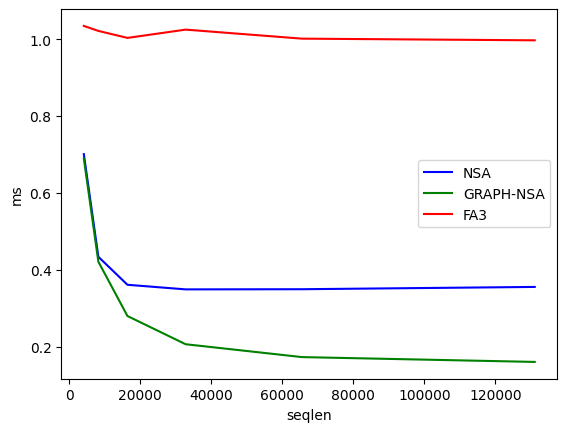

num_head=64, num_kv_head=4, head_dim=128, kv memory=4G, decoding:
     seqlen       NSA  GRAPH-NSA       FA3
0    4096.0  0.700775   0.689377  1.034566
1    8192.0  0.433544   0.420754  1.021608
2   16384.0  0.360706   0.279387  1.003379
3   32768.0  0.348726   0.205926  1.024930
4   65536.0  0.349135   0.172448  1.001430
5  131072.0  0.355115   0.159892  0.997100


In [33]:
from flash_nsa.inference import nsa_decode
from flash_attn_interface import flash_attn_with_kvcache

device = "cuda"
dtype = torch.bfloat16

t = 1024 * 2048
qh, kh, d = 64, 4, 128
total_blocks = 4096 * 4
block_size = 128

memory = t * kh * d * 2 * 2 / 1024 / 1024 / 1024

k = torch.randn(t, kh, d, device=device, dtype=dtype)
v = torch.randn(t, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)



torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seqlen'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in [4, 8, 16, 32, 64, 128]],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['NSA', "GRAPH-NSA", 'FA3'],  # possible values for `line_arg``
        line_names=[
            "NSA",
            "GRAPH-NSA",
            "FA3",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="num_head=64, num_kv_head=4, head_dim=128, kv memory=4G, decoding",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':64, 'kh':4, 'd':128},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(qh, kh, seqlen, d, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    
    B = 4 * 1024 * 1024 * 1024 // (seqlen * kh * 2 * 2 * d)
    
    q = torch.randn(B, qh, d, device=device, dtype=dtype)
    w = torch.randn(B, qh, 3, device=device, dtype=dtype)
    cmp_slot_mapping = torch.zeros(B, device=device, dtype=torch.int32)
    
    x_cu_seqlens = generate_cu_seqlens(t, seqlen, 0)
    NSAHelper.init_cu_seqlens(x_cu_seqlens)
    y_cu_seqlens = NSAHelper.y_cu_seqlens
    t2 = y_cu_seqlens[-1].item()
    
    cmp_block_tables,_= get_tabels(k[:t2], k_cache, y_cu_seqlens)
    block_tables, context_lens = get_tabels(k, k_cache, x_cu_seqlens)
    
    num_slc_blocks = triton.cdiv(seqlen, 64)
    fixd_y_maxlen = seqlen // 16
    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'GRAPH-NSA':
        
        g = torch.cuda.CUDAGraph()
        with torch.cuda.graph(g):
            o = nsa_decode(q, k_cache, v_cache, w, fixed_y_maxlen=fixd_y_maxlen, fixed_num_slc_blocks=num_slc_blocks,
                           context_lens=context_lens, block_tables=block_tables, cmp_block_tables=cmp_block_tables, cmp_slot_mapping=cmp_slot_mapping)
        ms = triton.testing.do_bench(lambda: g.replay())
    if provider == 'NSA':
        ms = triton.testing.do_bench(lambda: nsa_decode(q, k_cache, v_cache, w, fixed_y_maxlen=fixd_y_maxlen, fixed_num_slc_blocks=num_slc_blocks,
                                                        context_lens=context_lens, block_tables=block_tables, cmp_block_tables=cmp_block_tables, cmp_slot_mapping=cmp_slot_mapping))
    if provider == 'FA3':
        ms = triton.testing.do_bench(lambda: flash_attn_with_kvcache(q.unsqueeze(1), k_cache, v_cache, cache_seqlens=context_lens, page_table=block_tables, causal=True))
    return ms
benchmark.run(show_plots=True, print_data=True)

In [3]:
device = "cuda"
dtype = torch.bfloat16

ffn_size = 12288
hidden_size = 4096
qkvw_size = (64 + 4 + 4) * 128 + 64 * 3
o_size = 64 * 128

@torch.compile
def silu(x):
    gate, up = x.chunk(2, -1)
    return torch.nn.functional.silu(gate) * up

@torch.compile
def rms_forward(
    x: torch.Tensor,
    weight,
    eps=1e-16
) -> torch.Tensor:
    orig_dtype = x.dtype
    x = x.float()
    var = x.pow(2).mean(dim=-1, keepdim=True)
    x.mul_(torch.rsqrt(var))
    x = x.to(orig_dtype).mul_(weight)
    return x

bs = 256
fc1 = torch.randn(qkvw_size, hidden_size, device=device, dtype=dtype)
fc2 = torch.randn(hidden_size, o_size, device=device, dtype=dtype)
fc3 = torch.randn(ffn_size * 2, hidden_size, device=device, dtype=dtype)
fc4 = torch.randn(hidden_size, ffn_size, device=device, dtype=dtype)
x = torch.randn(bs, hidden_size, device=device, dtype=dtype)
q = torch.randn(bs, 64, 128, device=device, dtype=dtype)
k = torch.randn(bs, 4, 128, device=device, dtype=dtype)
o = torch.randn(bs, 64 * 128, device=device, dtype=dtype)
w1 = torch.randn(hidden_size, dtype=dtype, device=device)
w2 = torch.randn(128, dtype=dtype, device=device)

@torch.no_grad()
def func():
    rms_forward(x, w1)
    torch.matmul(x, fc1.t())
    rms_forward(q, w2)
    rms_forward(k, w2)
    torch.matmul(o, fc2.t())
    rms_forward(x, w1)
    gate_up = torch.matmul(x, fc3.t())
    down = silu(gate_up)
    out = torch.matmul(down, fc4.t())
    return out
    

In [4]:
print(triton.testing.do_bench(lambda: func()))
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    o = func()
print(triton.testing.do_bench(lambda: g.replay()))

0.22075250152926826
0.20584278306721346


# chunk_prefill demo

I dont know inference a lot, this is just a demo. 

It's obvious that the nsa kernel can support chunk prefill

In [9]:
from flash_nsa.inference import nsa_prefill
from flash_attn_interface import flash_attn_with_kvcache

device = "cuda"
dtype = torch.bfloat16
qh, kh, d = 64, 4, 128
total_blocks = 8192
block_size = 128
torch.cuda.empty_cache()

t = 8192

x_cu_seqlens = generate_cu_seqlens(t, 2048, 512)
# x_cu_seqlens = torch.tensor([0, 8120, 8192], device=device, dtype=torch.int32)
NSAHelper.init_cu_seqlens(x_cu_seqlens)
seqlens = NSAHelper.x_seqlens
x_maxlen = NSAHelper.x_maxlen
y_maxlen = NSAHelper.y_maxlen
y_cu_seqlens = NSAHelper.y_cu_seqlens
t2 = y_cu_seqlens[-1].item()

q = torch.randn(t, qh, d, device=device, dtype=dtype)
k = torch.randn(t, kh, d, device=device, dtype=dtype)
v = torch.randn(t, kh, d, device=device, dtype=dtype)
k_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
v_cache = torch.empty(total_blocks, block_size, kh, d, device=device, dtype=dtype)
w = torch.randn(t, qh, 3, device=device, dtype=dtype)

get_tabels(k, k_cache, x_cu_seqlens)
block_tables, context_lens, cmp_slot_mapping = get_tabels(v, v_cache, x_cu_seqlens, return_cmp_slot_mapping=True)
cmp_block_tables = block_tables
ref_o = nsa_prefill(q, k_cache, v_cache, w, x_cu_seqlens, y_cu_seqlens, x_maxlen, y_maxlen, context_lens=context_lens, cmp_slot_mapping=cmp_slot_mapping, cmp_block_tables=cmp_block_tables, block_tables=block_tables)
ref_cmp_k = k_cache.flatten(0, 1)[cmp_slot_mapping]
k_cache.flatten(0, 1)[cmp_slot_mapping].zero_()

B = len(x_cu_seqlens) - 1
chunks = 4
starts = x_cu_seqlens[:-1].cpu().tolist()
ends = x_cu_seqlens[1:].cpu().tolist()
chunk_seqlens = triton.cdiv(seqlens, chunks).cpu().tolist()
chunk_context_lens = torch.zeros_like(context_lens)
o = torch.zeros_like(ref_o)
for i in range(chunks):
    chunk_q = []
    chunk_w = []
    chunk_cmp_slot_mapping = []
    chunk_y_cu_seqlens = [0]
    chunk_x_cu_seqlens = [0]
    chunk_x_maxlen = 0
    chunk_y_maxlen = 0
    for j in range(B):
        chunk_start = starts[j] + i * chunk_seqlens[j]
        chunk_end = min(ends[j], chunk_start + chunk_seqlens[j])
        x_len = chunk_end - chunk_start
        old_y_len = max((chunk_start - starts[j] - 32) // 16 + 1, 0)
        y_len = max((chunk_end - starts[j] - 32) // 16 + 1, 0)
        chunk_cmp_slot_mapping += [-1] * old_y_len
        chunk_cmp_slot_mapping += cmp_slot_mapping[y_cu_seqlens[j] + old_y_len: y_cu_seqlens[j] + y_len].cpu().tolist()
        chunk_x_cu_seqlens.append(chunk_x_cu_seqlens[-1] + x_len)
        chunk_y_cu_seqlens.append(chunk_y_cu_seqlens[-1] + y_len)
        chunk_x_maxlen = max(chunk_x_maxlen, x_len)
        chunk_y_maxlen = max(chunk_y_maxlen, y_len)
        chunk_q.append(q[chunk_start:chunk_end])
        chunk_w.append(w[chunk_start:chunk_end])
        chunk_context_lens[j] += x_len
    chunk_q = torch.cat(chunk_q, 0)
    chunk_w = torch.cat(chunk_w, 0)
    chunk_x_cu_seqlens = torch.tensor(chunk_x_cu_seqlens, device=device, dtype=torch.int32)
    chunk_y_cu_seqlens = torch.tensor(chunk_y_cu_seqlens, device=device, dtype=torch.int32)
    chunk_cmp_slot_mapping = torch.tensor(chunk_cmp_slot_mapping, device=device, dtype=torch.int32)
    # chunk_cmp_slot_mapping, chunk_context_lens and chunk_y_cu_seqlens need pre chunks info
    chunk_o = nsa_prefill(chunk_q, k_cache, v_cache, chunk_w, chunk_x_cu_seqlens, chunk_y_cu_seqlens, chunk_x_maxlen, chunk_y_maxlen, 
                          context_lens=chunk_context_lens, cmp_slot_mapping=chunk_cmp_slot_mapping, cmp_block_tables=cmp_block_tables, block_tables=block_tables)
    bos = 0
    for j in range(B):
        chunk_start = starts[j] + i * chunk_seqlens[j]
        chunk_end = min(ends[j], chunk_start + chunk_seqlens[j])
        o[chunk_start:chunk_end] = chunk_o[bos:bos+chunk_end-chunk_start]
        bos += chunk_end - chunk_start
cmp_k = k_cache.flatten(0, 1)[cmp_slot_mapping]
compare(o, ref_o)
compare(cmp_k, ref_cmp_k)

max_diff: 0.00042724609375, mean_diff: 1.546140993013978e-11
max_diff: 0.0, mean_diff: 0.0
